In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas_datareader import data
from scipy.optimize import minimize
sns.set()
RISK_FREE_RATE = 0

### Download stocks data from Yahoo Finance

In [2]:
start_date = datetime(2010,1,1)
end_date =  datetime.now()
stocks = pd.DataFrame()
tickers = ['TCS.BO','MARUTI.BO','ITC.BO','HDFC.BO']

for ticker in tickers:
    df = data.DataReader(ticker,'yahoo',start=start_date,end=end_date)['Adj Close']
    name = ticker.split('.')[0].lower()
    df = df.to_frame(name=name)
    stocks = pd.concat([stocks,df],axis=1)

In [3]:
stocks.head()

,tcs,maruti,itc,hdfc
Date,,,,
2010-01-04,277.983490,1415.676147,62.122253,427.251465
2010-01-05,277.687500,1383.587524,62.722424,428.674347
2010-01-06,271.363831,1335.203979,62.808182,430.112885
2010-01-07,264.282043,1327.216187,62.685684,422.879364
2010-01-08,259.049316,1308.045532,62.820385,415.685791


In [4]:
stocks.dropna(inplace=True)
stocks.shape

(2686, 4)

## Mean Daily return

In [5]:
mean_daily_ret = stocks.pct_change(1).mean()
mean_daily_ret

tcs       0.001168
maruti    0.000778
itc       0.000556
hdfc      0.000773
dtype: float64

## Daily return correlation

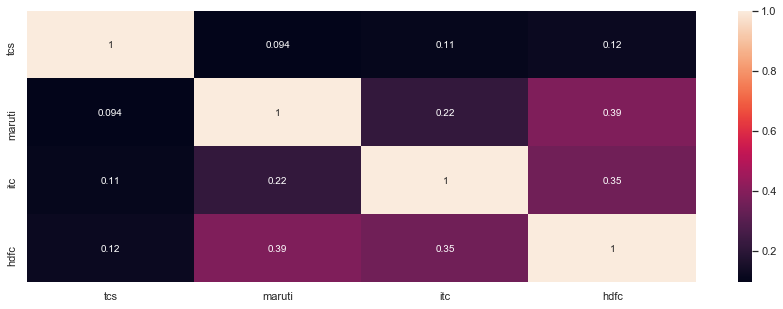

In [6]:
corr = stocks.pct_change(1).corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr,annot=True)

## Cumulative return

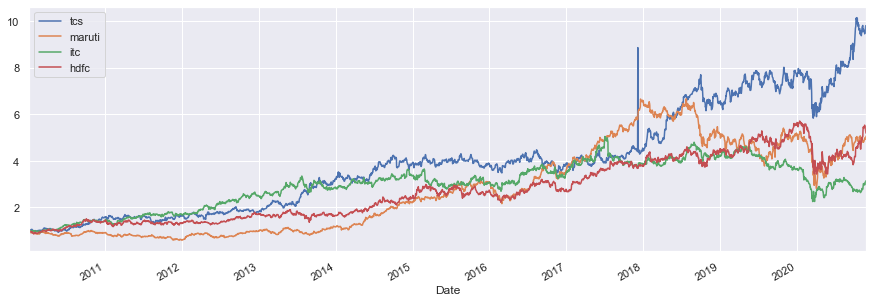

In [7]:
stock_normed = stocks/stocks.iloc[0]
stock_normed.plot(figsize=(15,5))

## Log Returns

In [8]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,tcs,maruti,itc,hdfc
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,-0.001065,-0.022927,0.009615,0.003325
2010-01-06,-0.023036,-0.035596,0.001366,0.003350
2010-01-07,-0.026444,-0.006000,-0.001952,-0.016961
2010-01-08,-0.019998,-0.014550,0.002147,-0.017157


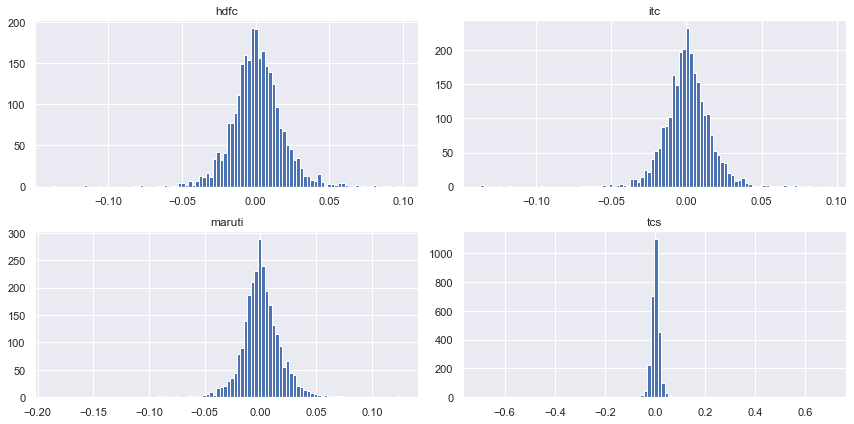

In [9]:
log_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [10]:
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tcs,2685.0,0.000850,0.024962,-0.697858,-0.007729,0.000739,0.009184,0.691704
maruti,2685.0,0.000604,0.018670,-0.186601,-0.008935,-0.000163,0.009902,0.125837
itc,2685.0,0.000427,0.016111,-0.137236,-0.007992,0.000334,0.008828,0.094448
hdfc,2685.0,0.000613,0.017879,-0.137719,-0.009137,0.000238,0.010375,0.098268


## Annualized Return

In [11]:
log_ret.mean() * 252

tcs       0.214139
maruti    0.152103
itc       0.107576
hdfc      0.154563
dtype: float64

## Covariance Matrix

In [12]:
log_ret.cov()

,tcs,maruti,itc,hdfc
tcs,0.000623,0.000045,0.000048,0.000061
maruti,0.000045,0.000349,0.000066,0.000130
itc,0.000048,0.000066,0.000260,0.000102
hdfc,0.000061,0.000130,0.000102,0.000320


In [13]:
log_ret.cov()*252 # multiply by days

,tcs,maruti,itc,hdfc
tcs,0.157020,0.011248,0.012182,0.015441
maruti,0.011248,0.087839,0.016597,0.032745
itc,0.012182,0.016597,0.065410,0.025810
hdfc,0.015441,0.032745,0.025810,0.080557


## Random Weights allocation

In [14]:
# Set seed
np.random.seed(71)

# generate random weights
weights = np.array(np.random.random(len(stocks.columns)))

# rebalance weights to sum to 1
weights = weights / np.sum(weights)
weights

array([0.11578422, 0.24120724, 0.51903712, 0.12397142])

### Portfolio expected return

In [15]:
# Expected portfolio return with random weights allocation
exp_ret = np.sum(log_ret.mean() * weights) *252
exp_ret

0.13647961430858993

### Portfolio Variance

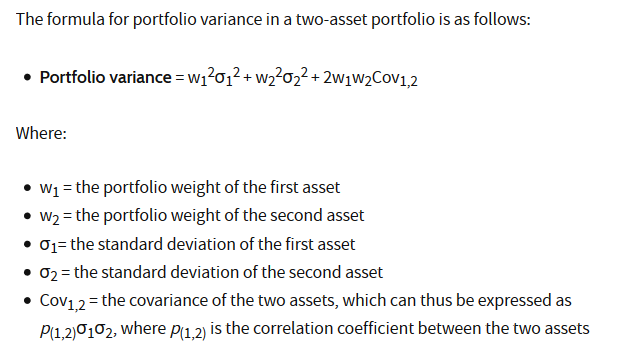

In [16]:
# portfolio variance using matrix notation
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
exp_vol

0.19505468088330685

In [17]:
# Sharpe Ratio
sr = (exp_ret-RISK_FREE_RATE)/exp_vol
sr

0.6996992519766293

### Monte Carlo Simulation

In [18]:
# Set seed
np.random.seed(71)

num_simulation = 15000

all_weights = np.zeros((num_simulation,len(stocks.columns)))
ret_arr = np.zeros(num_simulation)
vol_arr = np.zeros(num_simulation)
sharpe_arr = np.zeros(num_simulation)

for ind in range(num_simulation):
        
    # Create Random Weights
    weights = np.array(np.random.random(len(stocks.columns)))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = (ret_arr[ind]-RISK_FREE_RATE)/vol_arr[ind]
    
    print(f"\rRun: {ind}, Return: {ret_arr[ind]}, Voltality: {vol_arr[ind]},Sharpe: {sharpe_arr[ind]}",end='')


Run: 14999, Return: 0.16352032574767117, Voltality: 0.22878481157281805,Sharpe: 0.71473418459697715

In [19]:
print(f"Maximum sharpe ratio {sharpe_arr.max()}")
print(f"Portfolio weights for max sharpe ratio return {all_weights[sharpe_arr.argmax(),:]}")
print(f"Max return {ret_arr[sharpe_arr.argmax()]}")
print(f"Min Risk {vol_arr[sharpe_arr.argmax()]}")

Maximum sharpe ratio 0.8021103262794695
Portfolio weights for max sharpe ratio return [0.28711041 0.26827269 0.18653902 0.25807788]
Max return 0.16224286148537362
Min Risk 0.20227000721699387


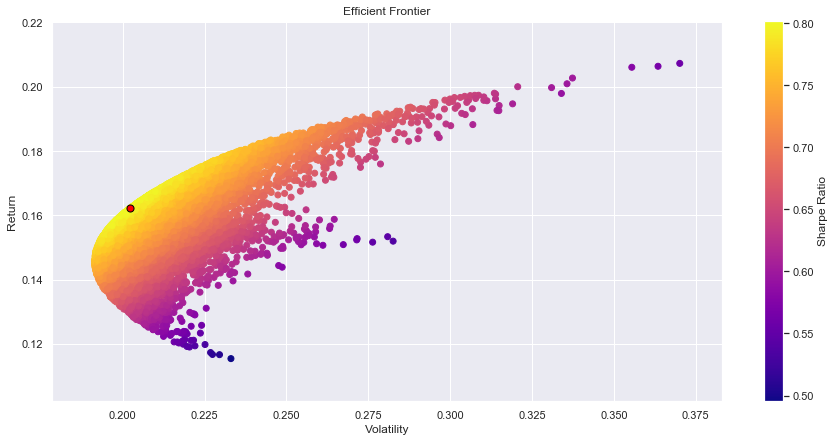

In [20]:
plt.figure(figsize=(15,7))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(vol_arr[sharpe_arr.argmax()],ret_arr[sharpe_arr.argmax()],c='red',s=50,edgecolors='black')

plt.title("Efficient Frontier");

# Mathematical Optimization

In [21]:
def get_ret_vol_sr(weights,RISK_FREE_RETURN=0):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = (ret-RISK_FREE_RETURN)/vol
    return np.array([ret,vol,sr])

# objective function
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# eq is for equality
# for eq type constraint function should return 0 for satisfied condition
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = []
for i in range(len(stocks.columns)):
    bounds.append((0,1))

In [22]:
# Initial Guess (equal distribution)
init_guess = []
for i in range(len(stocks.columns)):
    init_guess.append(1/len(stocks.columns))
init_guess

[0.25, 0.25, 0.25, 0.25]

In [23]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [24]:
opt_results

     fun: -0.8021371794323715
     jac: array([ 1.45435333e-05,  1.80520117e-04, -9.65744257e-05, -1.30966306e-04])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.28365428, 0.26686169, 0.19106216, 0.25842187])

In [25]:
# weights
opt_results.x

array([0.28365428, 0.26686169, 0.19106216, 0.25842187])

In [26]:
get_ret_vol_sr(opt_results.x)

array([0.1618279 , 0.20174592, 0.80213718])

### All Optimal Portfolios (Efficient Frontier)

In [27]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0.1,0.25,50) 

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [28]:
frontier_volatility = []

for idx, possible_return in enumerate(frontier_y):
    print(f"\rRunning Frontier: {idx}/{frontier_y.shape[0]}",end='')

    # constraints for sum and risk should be equal to frontier_y
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

Running Frontier: 49/50

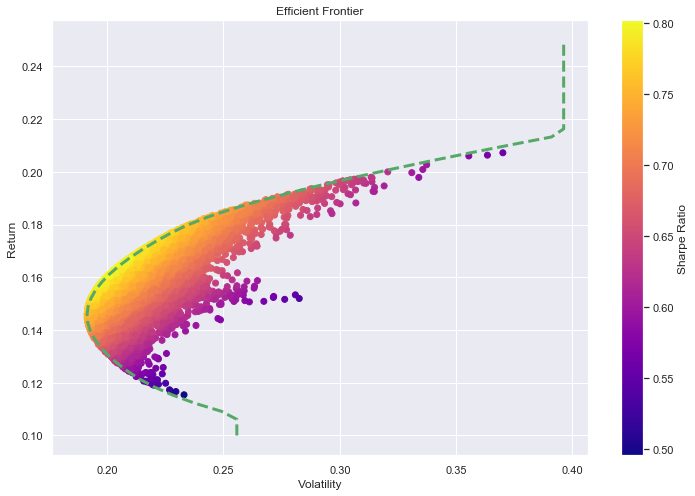

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title("Efficient Frontier");

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)